A Long Short-term Memory (LSTM) which predicts upwards or downwards trend for GOOG stock price for next 18 days. LSTM is a type of Recurring Neural Network (RNN), where we set the value of Recurring weights (W rec) as 1. 

LSTM is expected to perform better than ARIMA model. Dropout regularisation will avoid overfitting

# Part 1: Data Preprocessing

## Importing the libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing the Training set

Keeping separate the training and test set so that RNN is not acquainted with test set. 

Creating a numpy array from the open price column using iloc because that is what we are interested in

In [39]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values
# : selects all the rows. we use  1:2 for selecting column 2 because that lower bound is selected and upper bound is ingnored

## Feature Scaling
Two common ways of applying Feature Scaling are:

* **Standardisation** X(stand) = [X - mean(X)] / stdev(X)

* **Normalisation** X(norm) = [X - min(X)] / [max(X) - min(X)]

If there is a sigmoid activation function involved in the construction of an RNN, it is recommended to apply Normalisation. MinMaxScalar class from scikit learn library is used to do this

In [40]:
from sklearn.preprocessing import MinMaxScaler
# creating an object sc in minmaxscalar class. Normalising(Scaling) stock prices between 0 and 1
sc = MinMaxScaler(feature_range = (0,1))
# using fit_transform method for scaling training_set
training_set_scaled = sc.fit_transform(training_set)

## Number of timesteps and output
This datastructure specifies what our RNN needs to remember when predicting next stock price. 

It is important to have an optimal number of timesteps or else it might lead to overfitting or non-sense predictions

Here we choose 60 timesteps (approx. 3 months since we have daily data) and 1 output. This means that our RNN will try to learn from 60 past prices to understand some trend and on the basis of that, it will predict the next price


In [41]:
# Creating empty lists for inputs to Neural Network (x_train) and output (y_train)
# for each day x_train will contain 60 previous day prices, and y_train will contan next day's predicted price
x_train = []
y_train = []
# populating these empty lists with a for loop. we need to start with the 61st observation to get 60 previous prices
# Total observations in training set are 1257
for i in range(60, 1258):
  x_train.append(training_set_scaled[i-60 : i, 0]) # choosing previous 60 observations in column 1 (We only have one column)
  y_train.append(training_set_scaled[i , 0])
# creating a numpy array with these lists
x_train, y_train = np.array(x_train), np.array(y_train)

## Reshaping
Adds the number of predictors to predict stock prices. This could be other stock's prices or another time-series data. It is done using input_dim
Keras expects inputs for RNN as N-D tensor with shape [batch_size, timesteps, ...] or [timesteps, batch_size, ...] when time_major is True.

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# selecting number of rows uisng [0] and number of columns using [1]. The 1 at the end is the number of predictors 

# Part 2: Building an RNN
a stacked LSTM with dropout  regularisation to avoid overfitting

## Importing Keras libraries and packages

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Initialising the RNN
Initialise the Reccuring Neural Network as a sequence of layers.

We are predicting continuous outcomes (prices), hence we need to perform regression

In [44]:
regressor = Sequential()

## Adding first LSTM layer and dropout regularisation

it is better to choose a large number of units(neurons) for higher dimensionality. Return sequences is set to True because we have multiple layers. Using dropout we can specify the number of neurons to ignore during regularisation. Here we use 20% dropout. So during forward and backpropagation 20% of neurons (10) will be ignored

In [45]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

## Adding second LSTM layer and dropout regularisation
we do not need to specify the input shape again when adding next LSTM layer

In [46]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

## Adding third LSTM layer and dropout regularisation
same as above

In [47]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

## Adding fourth LSTM layer and dropout regularisation
Since, this is the final layer of our RNN, we set return_sequences to False or remove it, because we are not returning any sequences here

In [48]:
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

## Adding the output layer
Since we only have one predicted output (price) we have one unit.
Dense class is fully connected to other layers, so we use it for output

In [49]:
regressor.add(Dense(units = 1))

## Compiling the RNN
A lot of optimisers can be used. Keras suggests to use RMSprop for RNN networks https://keras.io/api/optimizers/. We can also try Adam optimiser to see the difference later

In [50]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

## Fitting the RNN to the Training Set
If we try to minimise the loss to an extreme extent, it would indicate overfitting

In [51]:
regressor.fit(x = x_train, y = y_train, batch_size = 32, epochs = 100 )

Epoch 1/100
38/38 [==============================] - 12s 126ms/step - loss: 0.0322
Epoch 2/100
38/38 [==============================] - 5s 123ms/step - loss: 0.0148
Epoch 3/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0121
Epoch 4/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0099
Epoch 5/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0098
Epoch 6/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0093
Epoch 7/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0080
Epoch 8/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0069
Epoch 9/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0072
Epoch 10/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0072
Epoch 11/100
38/38 [==============================] - 5s 124ms/step - loss: 0.0058
Epoch 12/100
38/38 [==============================] - 5s 126ms/step - loss: 0.0062
Epoch 13/100

# Part 3: Making Predictions and Visualising Results

## Getting the real GOOG price

In [52]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

# Predicting price for GOOG

We would need to concatenate prices from the training set to test set so that for each day in test set we have access to previous 60 day open prices

But concatenation need to be performed on original dataset_train and dataset_test. From this concatenation we would get input from each prediction (i.e. the 60 previous prices at each time t), which will then be scaled. We are only scaling the inputs and not changing actual test values.

We need to scale inputs here because our RNN was trained on scaled inputs



In [53]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0) # for vertical concatenation, axis = 0
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values
# we are choosing 60 previous values from dataset_train for our prediction number 1
inputs = inputs.reshape(-1, 1) # this gets input for stock prices in 1 column
inputs = sc.transform(inputs) 
# scaling the inputs. do not need to use fit_transform because sc object was already fitted to training set
# scaling must be the same on which our regressor was trained

In [54]:
# we do not need y_test because we making predictions
# the test set contains only 20 financial days so the upper bound in for loop would be 60+20 = 80
x_test = []
for i in range (60, 80):
  x_test.append(inputs[i-60 : i, 0])
x_test = np.array(x_test)
# creating a 3-d structure for keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [55]:
# saving predictions in predicted_stock_price
predicted_stock_price = regressor.predict(x_test)
# applying the inverse transform scaling method to get unscaled values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

## Visualising the results

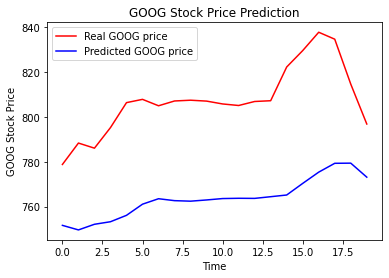

In [57]:
# plotting the real GOOG stock price
plt.plot(real_stock_price, color = 'red', label = 'Real GOOG price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted GOOG price')
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show()

In most parts of our predictions we see predicted results lagging the actual price. Our model can not react fast enough to sudden chances, But model reacts very well to smooth changes and manages to follow the trend

# Part 4: Closing Comments

**Some ways to further improve the RNN model:**

  Getting more training data

  Increasing the number of timesteps

  Adding some other indicators (other stocks which might be correlated to our chosen stock

  Adding more LSTM layers: this RNN had four LSTM layers but it could be experimented with

  Adding more neurons in the LSTM layers